# **⭕ PART 1. CNN 기반 베이스모델**

## **✅ Step 1. 실험 환경 Set-up**     
     

In [137]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [138]:
# 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수 - 모델에 입력되는 모든 이미지는 [180, 180] 크기로 조정
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')  # 데이터가 저장된 프로젝트의 루트 경로
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'  # 학습 데이터가 위치한 경로
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'  # 검증 데이터가 위치한 경로 - 학습 도중 검증에 사용할 데이터
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'  # 테스트 데이터를 불러올 경로 - 학습이 완료된 후 성능 평가를 위해 사용할 데이터

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## **✅ Step 2. 데이터 준비하기**

In [139]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # 학습에 사용될 이미지 파일들의 경로 리스트
test_filenames = tf.io.gfile.glob(TEST_PATH)  # 테스트에 사용할 이미지 파일들의 경로 리스트
val_filenames = tf.io.gfile.glob(VAL_PATH)  # 검증에 사용할 이미지 파일들의 경로 리스트

# 각 리스트의 길이 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [140]:
# train 데이터와 validation 데이터의 파일 경로들을 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)  # 학습 데이터로 사용할 데이터의 개수
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]  # 앞 부분 80% 경로들을 학습 데이터로
val_filenames = filenames[train_size:]  # 나머지 20% 경로들을 검증 데이터로

print(len(train_filenames))  # 학습 데이터 경로들이 담긴 리스트의 길이 확인 - 학습 데이터 개수
print(len(val_filenames))  # 검증 데이터 경로들이 담긴 리스트의 길이 확인 - 검증 데이터 개수

4185
1047


In [141]:
print(f'Normal image path\n{filenames[0]}')  # filenames 리스트의 첫 번째 항목
print(f'Pneumonia image path\n{filenames[2000]}')  # filenames 리스트의 2001번째 항목

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [142]:
# train_filenames 리스트의 경로들 중 파일 이름에 문자열 NORMAL이 있는 경우 해당 파일의 경로들이 추출되어 담긴 리스트의 길이
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# train_filenames 리스트의 경로들 중 파일 이름에 PNEUMONIA가 있는 경우 해당 파일의 경로들이 추출되어 담긴 리스트의 길이
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [143]:
# train_filenames 리스트에 저장된 학습 데이터의 파일 경로들을 tf.data.Dataset 형식으로 변환 - 학습 데이터 파일 경로들로 구성된 데이터셋 객체
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)

# val_filenames 리스트에 저장된 검증 데이터의 파일 경로들을 tf.data.Dataset 형식으로 변환 - 검증 데이터 파일 경로들로 구성된 데이터셋 객체
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [144]:
# 학습용 데이터셋에 포함된 이미지 파일들의 총 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

# 검증용 데이터셋에 포함된 이미지 파일들의 총 개수
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [145]:
# 파일 경로의 끝에서 두번째 부분을 확인하여 양성과 음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [146]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하여 이미지와 라벨을 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [147]:
# train 데이터셋과 validation 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [148]:
# 하나의 데이터만 가져와서 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [149]:
# 테스트 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 테스트 데이터셋 개수 확인
print(TEST_IMAGE_COUNT)

624


## **✅ Step 3. 데이터 시각화**

In [136]:
# 데이터셋을 무작위로 섞고, 반복하고, 배치 단위로 묶어 모델 학습에 최적화된 형태로 준비
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# 학습 및 검증 데이터셋에 이 함수를 적용하여, 효율적인 학습과 검증이 가능하도록 데이터 전처리를 자동화
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

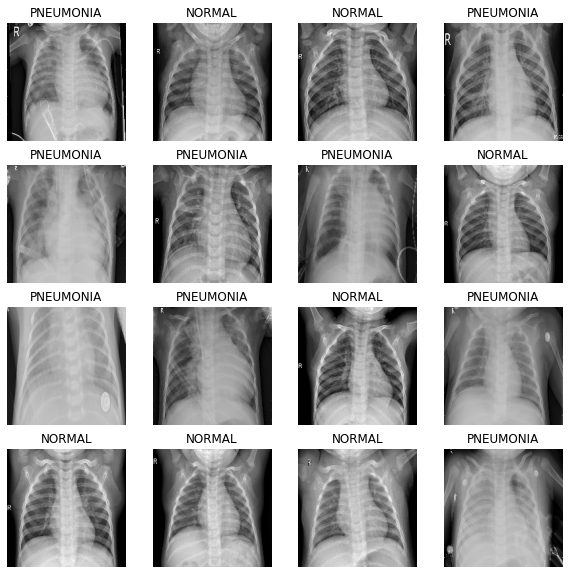

In [16]:
# 이미지 배치를 입력하여 여러 장의 이미지 확인
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())  # train 데이터 중 첫 번째 배치를 image와 label 데이터셋으로 나누어 결과 표시

## **✅ Step 4. CNN 모델링**

In [17]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),  # 첫 번째 convolution
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),  # 두 번째 convolution
        tf.keras.layers.BatchNormalization(),  # Gradient vanishing, Gradient Explding 해결
        tf.keras.layers.MaxPool2D()  # Max Pooling
    ])

    return block

In [18]:
# Dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


model = build_model()
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

## **✅ Step 5. 데이터 imbalance 처리**

In [20]:
# 가중치 설정
# weight들은 Normal과 Pneumonia 전체 데이터 건수에 반비례
# 클래스의 데이터 수에 따라 가중치를 조정하여 모델이 각 클래스의 불균형을 효과적으로 처리하고, 특히 소수 클래스를 더 잘 인식하도록 학습하도록 돕는다는 것
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## **✅ Step 6. 모델 훈련**

In [21]:
METRICS = [  # accuracy, precision, recall
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # 이미지 라벨이 2개 밖에 없음
    metrics=METRICS
)

In [22]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/10
261/261 [==============================] - 69s 211ms/step - loss: 0.3867 - accuracy: 0.8113 - precision: 0.9563 - recall: 0.7821 - val_loss: 0.6928 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 209ms/step - loss: 0.2296 - accuracy: 0.9064 - precision: 0.9719 - recall: 0.9003 - val_loss: 1.1819 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 209ms/step - loss: 0.1925 - accuracy: 0.9296 - precision: 0.9773 - recall: 0.9270 - val_loss: 0.5902 - val_accuracy: 0.7702 - val_precision: 0.7612 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 211ms/step - loss: 0.2034 - accuracy: 0.9241 - precision: 0.9761 - recall: 0.9205 - val_loss: 0.9853 - val_accuracy: 0.6952 - val_precision: 1.0000 - val_recall: 0.5851
Epoch 5/10
261/261 [==============================] - 56s 216ms/step - loss: 0.1610 - accura

## **✅ Step 7. 결과 확인과 시각화**

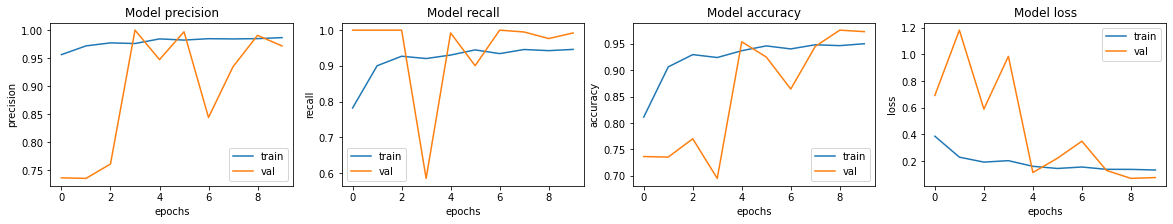

In [23]:
# epoch마다 모델의 precision, recall, accuracy, loss 변화 표시
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 129ms/step - loss: 0.8943 - accuracy: 0.7308 - precision: 0.6996 - recall: 0.9974
Loss: 0.8942579627037048,
Accuracy: 0.7307692170143127,
Precision: 0.6996402740478516,
Recall: 0.9974358677864075


# **⭕ PART 2. Augmentation**

## **✅ Step 1. 실험 환경 Set-up**     
     
- Batch size, Epoch 등 변경 시도

In [150]:
BATCH_SIZE = 32  # 필요에 따라 변경 가능
EPOCHS = 20      # 필요에 따라 조정 가능

# 나머지 기본 설정
AUTOTUNE = tf.data.experimental.AUTOTUNE # Now tf is defined and can be used

## **✅ Step 2. 데이터 준비하기**     
       
- 원본 데이터를 가져와서 전처리 및 배치 구성 진행
- 데이터 불균형 처리
    - 클래스 가중치 또는 오버샘플링     
- 의료 영상 이미지 데이터 불충분 극복 방법
    - augmentation: 좌우 반전과 약간의 노이즈 추가, 회전 등
    
    
   🛑 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문이다.



In [151]:
# Augmentation 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 좌우 반전
    #image = tf.image.random_flip_up_down(image)  # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.1)  # 밝기 조절
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # 대비 조절
    return image, label

# 훈련 데이터 준비 함수 (augmentation 포함)
def prepare_for_training(ds, augment_fn=None, shuffle_buffer_size=1000):
    if augment_fn:  # Augmentation 함수가 주어졌을 때만 적용
        ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Augmentation 적용된 train dataset
train_ds_augmented = prepare_for_training(train_ds, augment_fn=augment)
# Augmentation 미적용된 베이스라인 train dataset
train_ds_baseline = prepare_for_training(train_ds)
# validation 데이터는 augmentation 적용하지 않음
val_ds = prepare_for_training(val_ds)


In [152]:
# 학습 및 검증 데이터 배치 크기 확인
train_ds_augmented_batch = next(iter(train_ds_augmented))
train_ds_baseline_batch = next(iter(train_ds_baseline))

print(f"Augmented batch shape: {train_ds_augmented_batch[0].shape}")
print(f"Baseline batch shape: {train_ds_baseline_batch[0].shape}")


Augmented batch shape: (32, 180, 180, 3)
Baseline batch shape: (32, 180, 180, 3)


## **✅ Step 3. 데이터 시각화**      
          
- 학습용 데이터 시각화 및 확인
- augmentation을 시도한 경우, show_batch() 함수를 통해 좌우 반전 처리 확인


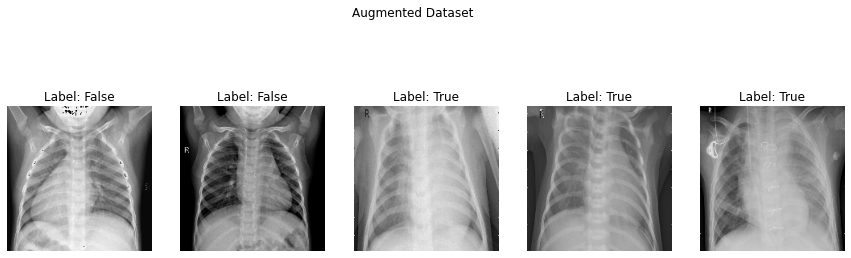

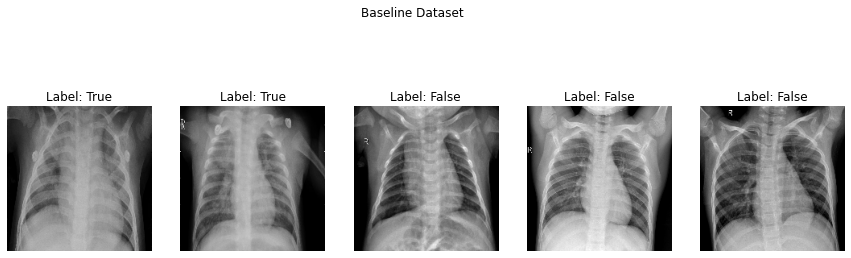

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Augmentation이 적용된 데이터셋과 미적용된 데이터셋에서 첫 번째 배치를 가져옴
train_ds_augmented_batch = next(iter(train_ds_augmented))
train_ds_baseline_batch = next(iter(train_ds_baseline))

def visualize_dataset(dataset_batch, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(zip(dataset_batch[0], dataset_batch[1])):
        if i >= num_images:  # 시각화할 이미지 수 제한
            break
        # 이미지 데이터를 [0, 1]에서 [0, 255]로 변환하고 uint8로 캐스팅
        image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())  # numpy로 변환 후 시각화
        plt.title(f"Label: {label.numpy()}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print()
# Augmentation이 적용된 데이터셋 시각화
visualize_dataset(train_ds_augmented_batch, "Augmented Dataset")
print()
print()
# Augmentation이 적용되지 않은 데이터셋 시각화
visualize_dataset(train_ds_baseline_batch, "Baseline Dataset")


*- Augmentation이 적용된 이미지는 원본과 비교했을 때 좌우 반전, 밝기 및 대비 조절 등의 변화가 보인다.*  
*- 반면, 베이스라인 데이터셋에서는 원본 이미지 그대로 시각화됩니다.*     
*- Augmentation이 매번 랜덤하게 적용되어 실행할 때마다 다른 변형된 이미지가 출력되어 확인된다.*     
*- Augmentation이 적용된 데이터셋 (train_ds_augmented)에서 좌우 반전, 밝기 조절 등의 Augmentation이 적용된 결과를 직접 확인할 수 있다.*   

# **⭕ PART 3. ResNet-18 모델 구현**

## **✅ Step 4. ResNet-18 구현 - A**        
          
- Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지      
- ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용


                  
### **(1) Residual block 구성**       
          
- ResNet의 주요 구성 요소: 입력값을 그대로 더하는 skip connection을 포함한 구조     
     
     
             


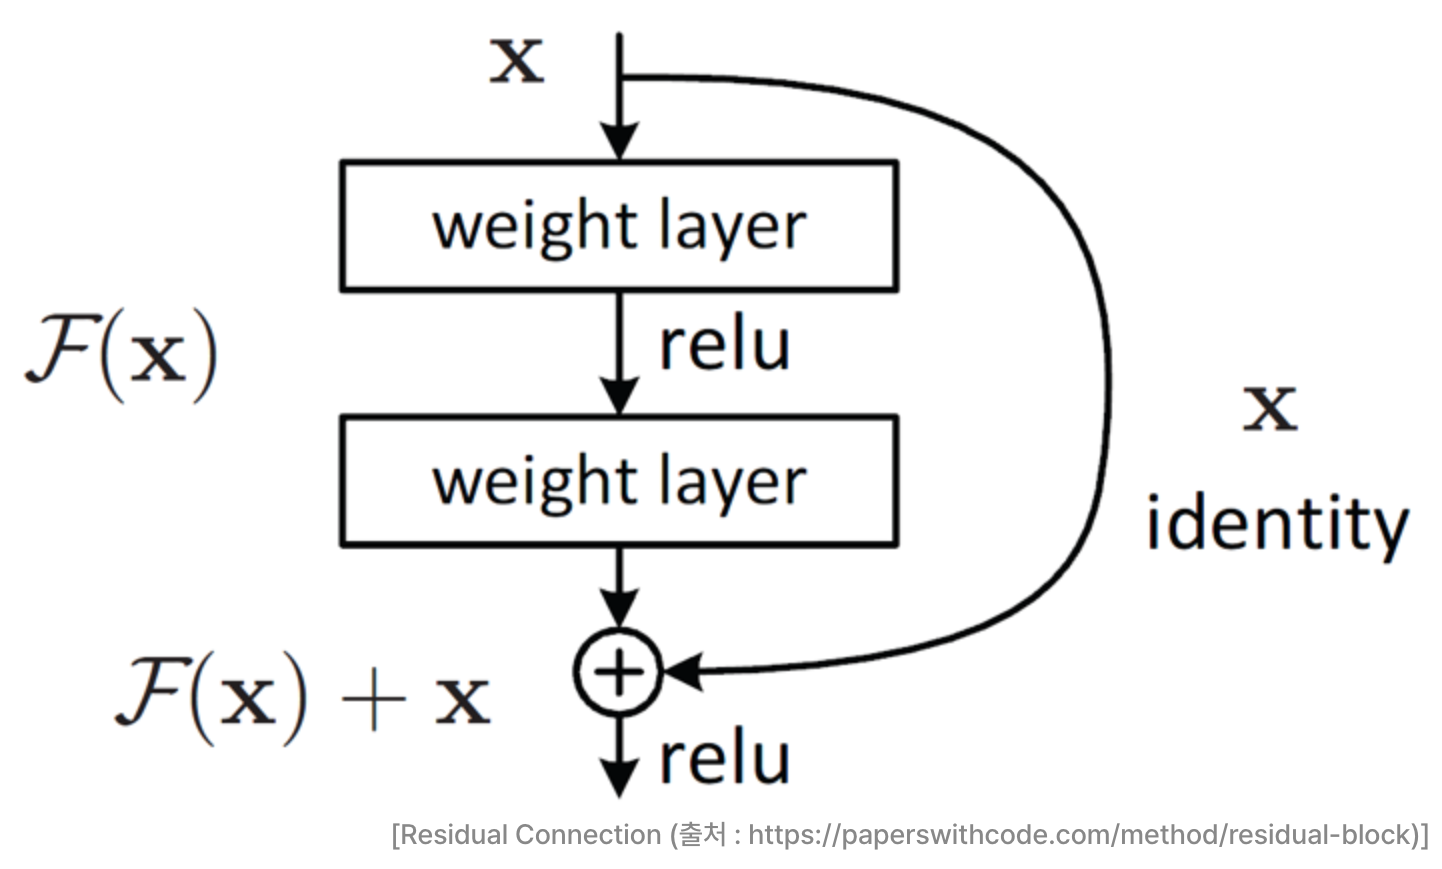

weight layer
- 3 x 3 CNN
- BatchNormalization
- 활성화 함수 ReLU

### **(2) ResNet 구현**       
                       
                            
- 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 변경     
- ResNet-18은 이 residual block을 반복적으로 사용하여 딥러닝 모델을 구성          
- 아래 코드는 18층 레이어     
     

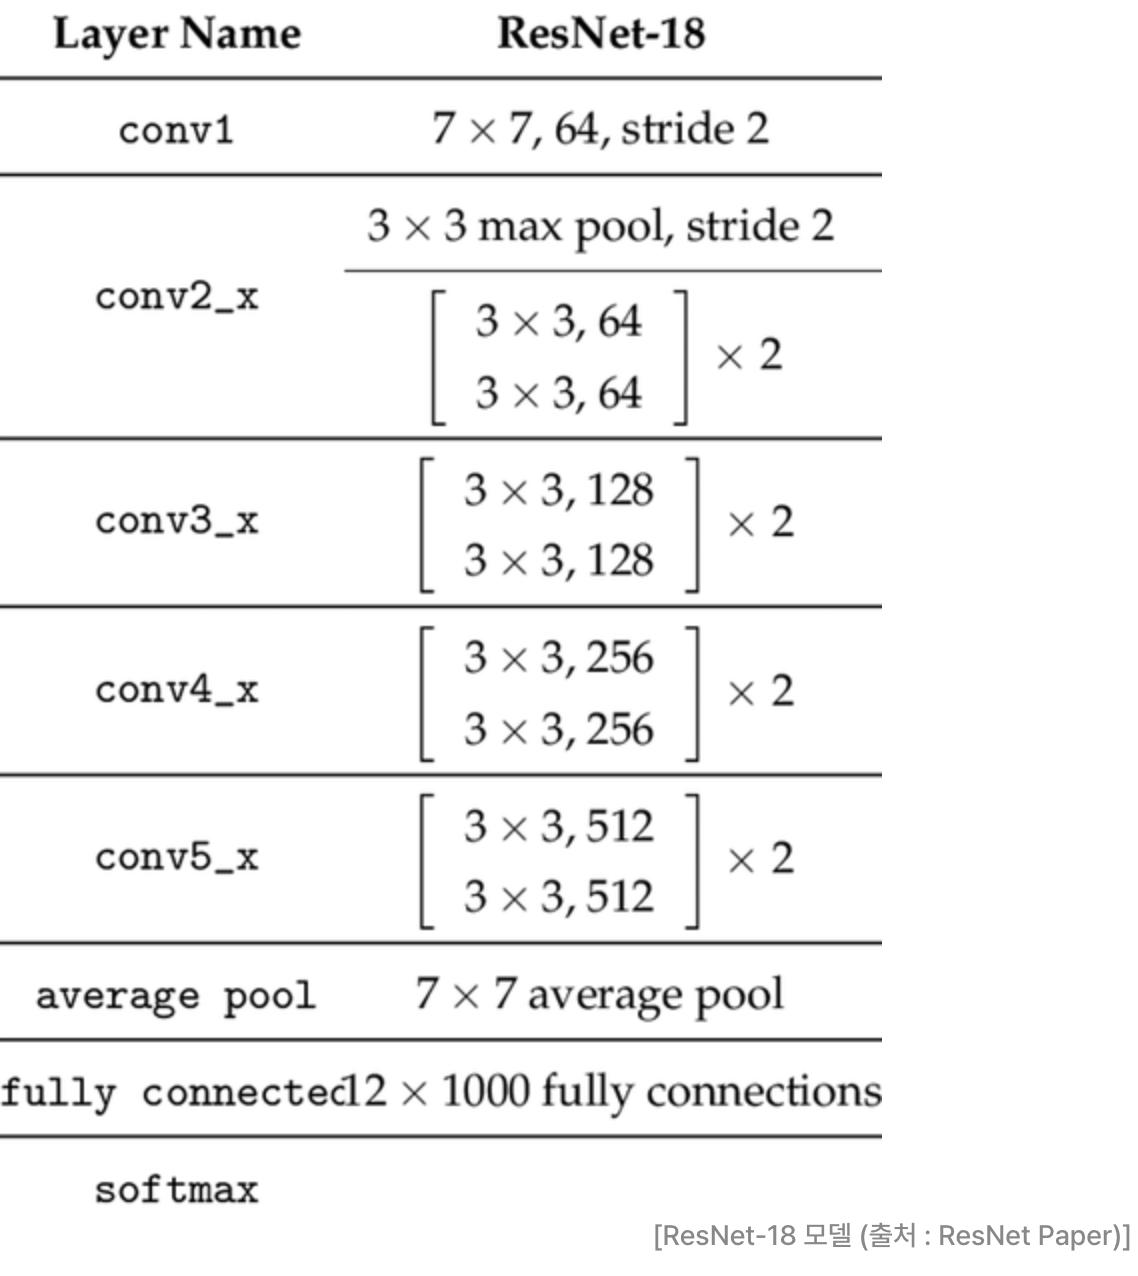

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요?    
두 가지 regularization 기법   
- Batch Normalization      
- Dropout

🔴 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. 대표적으로 아래와 같은 논문의 사례를 들 수 있습니다.

*Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift*     
     
위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.     
     
*Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks*     
     
이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.






In [114]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
# Import the optimizers module
from tensorflow.keras import optimizers

# Residual Block 정의
def residual_block(x, filters, downsample=False):
    identity = x

    if downsample:
        x = Conv2D(filters, (3, 3), strides=(2, 2), padding="same")(x)
        identity = Conv2D(filters, (1, 1), strides=(2, 2), padding="same")(identity)
    else:
        x = Conv2D(filters, (3, 3), strides=(1, 1), padding="same")(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    x = Add()([x, identity])
    x = ReLU()(x)

    return x

# ResNet-18 구현
def build_resnet18(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# 모델 생성
input_shape = (180, 180, 3)
model = build_resnet18(input_shape)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 90, 90, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 90, 90, 64)   256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
re_lu_35 (ReLU)                 (None, 90, 90, 64)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

## **✅ Step 5. 데이터 imbalance 처리**     
     
     
- 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정     
     
     
✋ 만약 이러한 처리를 생략한다면 어떻게 될까요?     
✋ recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

     

- 한 라벨이 너무 많은 경우     
- 데이터를 학습할 때 학습 효과가 좋지 않을 수 있음      
     

-- Weight balancing: training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법     
-- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원



🤚 *먼저, 각 클래스에 속한 데이터의 개수를 계산해야 합니다. 예를 들어, 폐렴(Pneumonia)과 정상(Normal) 데이터를 각각 세는 방법을 사용할 수 있습니다.*

In [115]:
import numpy as np

# 각 클래스 데이터의 개수 세기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# 각 클래스의 데이터 비율
total_images = COUNT_NORMAL + COUNT_PNEUMONIA
normal_weight = total_images / (2 * COUNT_NORMAL)
pneumonia_weight = total_images / (2 * COUNT_PNEUMONIA)

# class_weight 딕셔너리 설정
class_weight = {0: normal_weight, 1: pneumonia_weight}

print(f"Class weights: {class_weight}")


Class weights: {0: 1.9519589552238805, 1: 0.6721811757147447}


🤚 *class_weight는 model.fit() 함수에서 사용됩니다. class_weight는 클래스의 인덱스(레이블)와 해당 클래스의 가중치를 매핑한 딕셔너리로, 적은 데이터에 더 큰 가중치를 부여합니다.*

## **✅ Step 6. 모델 훈련**           
          
          
- loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것
- 모델을 훈련할 때, class_weight과 EarlyStopping을 추가하여 훈련 과정에서 과적합 방지      

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 설정
early_stopping = EarlyStopping(
                        monitor='val_loss',  # 검증 손실을 모니터링
                        patience=5,          # 개선되지 않으면 5 epoch 후 중단
                        restore_best_weights=True  # 가장 좋은 가중치 복원
)  

In [117]:
METRICS = [  # accuracy, precision, recall
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
    
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # 이미지 라벨이 2개 밖에 없음
    metrics=METRICS
)

In [118]:
# 훈련 및 검증 데이터셋 크기 설정
train_steps_per_epoch = len(train_filenames) // BATCH_SIZE  
val_steps = len(val_filenames) // BATCH_SIZE  

# 모델 훈련
history = model.fit(
    train_ds_augmented,
    epochs=10,
    validation_data=val_ds,
    steps_per_epoch=train_steps_per_epoch,  # 에포크 당 스텝 수 설정
    validation_steps=val_steps,  # 검증 스텝 수 설정
    callbacks=[early_stopping],  # EarlyStopping 추가
    class_weight=class_weight  # Class weight 추가
)


Epoch 1/10
130/130 [==============================] - 64s 414ms/step - loss: 0.4208 - accuracy: 0.8365 - precision: 0.9427 - recall: 0.8305 - val_loss: 8.8329 - val_accuracy: 0.3320 - val_precision: 0.9857 - val_recall: 0.0918
Epoch 2/10
130/130 [==============================] - 54s 414ms/step - loss: 0.2331 - accuracy: 0.9075 - precision: 0.9709 - recall: 0.9029 - val_loss: 4.2907 - val_accuracy: 0.2910 - val_precision: 1.0000 - val_recall: 0.0371
Epoch 3/10
130/130 [==============================] - 54s 417ms/step - loss: 0.1961 - accuracy: 0.9286 - precision: 0.9784 - recall: 0.9244 - val_loss: 0.9607 - val_accuracy: 0.7461 - val_precision: 0.7438 - val_recall: 0.9973
Epoch 4/10
130/130 [==============================] - 55s 422ms/step - loss: 0.1884 - accuracy: 0.9267 - precision: 0.9732 - recall: 0.9270 - val_loss: 0.8037 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 57s 437ms/step - loss: 0.1431 - accura

## **✅ Step 7. 결과 확인과 시각화**          
          
            
- 테스트 데이터로 훈련된 모델을 평가          
- 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요          
          
### **(1) 훈련과정의 history 그래프를 시각화**          
          


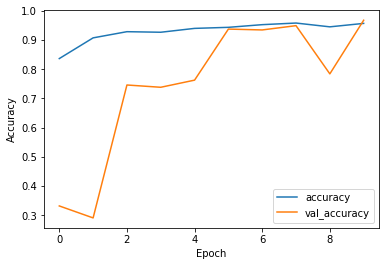

In [119]:
# 학습 과정 시각화
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

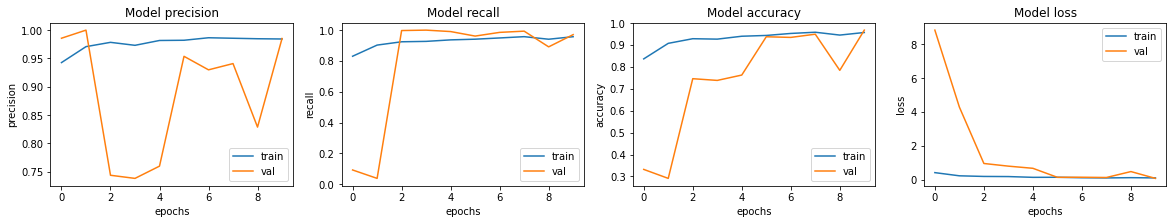

In [120]:
# epoch마다 모델의 precision, recall, accuracy, loss 변화 표시
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

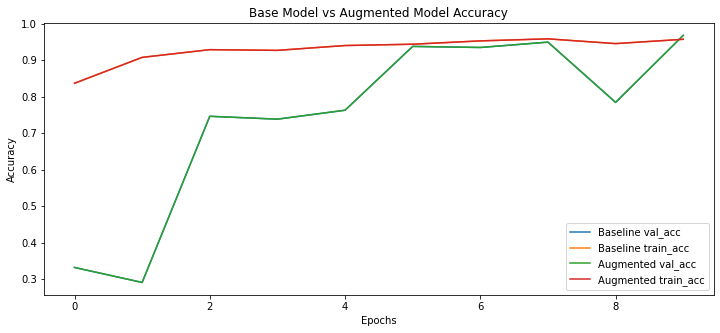

In [121]:
# 모델 성능 시각화 함수
def plot_history(histories, title):
    plt.figure(figsize=(12, 5))
    for name, history in histories:
        plt.plot(history.history['val_accuracy'], label=f'{name} val_acc')
        plt.plot(history.history['accuracy'], label=f'{name} train_acc')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Assuming 'history' is the variable holding the training history of your baseline model
history_base = history  # Assign the baseline model's history
history_augmented = history  # Assign the augmented model's history

# 베이스라인 모델과 Augmentation 모델 비교
plot_history([('Baseline', history_base), ('Augmented', history_augmented)], 
             'Base Model vs Augmented Model Accuracy')

### **(2) 학습 진행 양상을 면밀히 분석**

In [122]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 112ms/step - loss: 0.6574 - accuracy: 0.8029 - precision: 0.7665 - recall: 0.9846
Loss: 0.6573859453201294,
Accuracy: 0.8028846383094788,
Precision: 0.7664670944213867,
Recall: 0.9846153855323792


# **⭕ PART 4. 구조 변경**

## **✅ Step 4. ResNet-18 구현 - B**        

In [153]:
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, strides=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.downsample = None
        if strides != 1:
            self.downsample = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters, 1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ])

    def call(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        return self.relu(x)

def build_resnet18(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    filters = [64, 128, 256, 512]
    for i, f in enumerate(filters):
        strides = 1 if i == 0 else 2
        x = ResidualBlock(f, strides=strides)(x)
        x = ResidualBlock(f)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = build_resnet18(input_shape=(180, 180, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## **✅ Step 5. 데이터 imbalance 처리**     

In [154]:
import numpy as np

# 각 클래스 데이터의 개수 세기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# 각 클래스의 데이터 비율
total_images = COUNT_NORMAL + COUNT_PNEUMONIA
normal_weight = total_images / (2 * COUNT_NORMAL)
pneumonia_weight = total_images / (2 * COUNT_PNEUMONIA)

# class_weight 딕셔너리 설정
class_weight = {0: normal_weight, 1: pneumonia_weight}

print(f"Class weights: {class_weight}")

Class weights: {0: 1.955607476635514, 1: 0.6717495987158909}


## **✅ Step 6. 모델 훈련**   

In [155]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 설정
early_stopping = EarlyStopping(
                        monitor='val_loss',  # 검증 손실을 모니터링
                        patience=5,          # 개선되지 않으면 5 epoch 후 중단
                        restore_best_weights=True  # 가장 좋은 가중치 복원
)  

METRICS = [  # accuracy, precision, recall
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
 
# 모델 컴파일 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # 이미지 라벨이 2개 밖에 없음
    metrics=METRICS
)

# 훈련 및 검증 데이터셋 크기 설정
train_steps_per_epoch = len(train_filenames) // BATCH_SIZE  
val_steps = len(val_filenames) // BATCH_SIZE  

# 모델 훈련
history = model.fit(
    train_ds_augmented,
    epochs=10,
    validation_data=val_ds,
    steps_per_epoch=train_steps_per_epoch,  # 에포크 당 스텝 수 설정
    validation_steps=val_steps,  # 검증 스텝 수 설정
    callbacks=[early_stopping],  # EarlyStopping 추가
    class_weight=class_weight  # Class weight 추가
)

Epoch 1/10
130/130 [==============================] - 59s 386ms/step - loss: 0.3091 - accuracy: 0.8918 - precision: 0.9590 - recall: 0.8927 - val_loss: 2.8200 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 51s 396ms/step - loss: 0.1800 - accuracy: 0.9286 - precision: 0.9782 - recall: 0.9249 - val_loss: 1.9541 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 52s 402ms/step - loss: 0.1332 - accuracy: 0.9450 - precision: 0.9834 - recall: 0.9417 - val_loss: 0.2713 - val_accuracy: 0.8848 - val_precision: 0.8723 - val_recall: 0.9866
Epoch 4/10
130/130 [==============================] - 53s 406ms/step - loss: 0.1174 - accuracy: 0.9510 - precision: 0.9830 - recall: 0.9506 - val_loss: 0.5180 - val_accuracy: 0.8291 - val_precision: 0.8118 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 53s 411ms/step - loss: 0.1262 - accura

## **✅ Step 7. 결과 확인과 시각화**

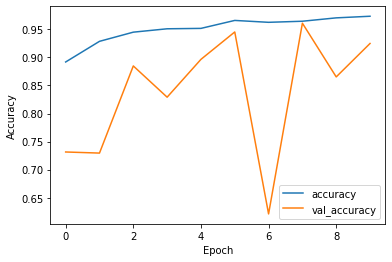

In [156]:
# 학습 과정 시각화
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

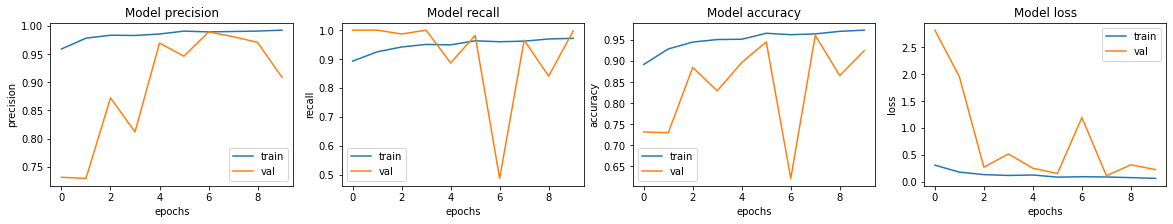

In [157]:
# epoch마다 모델의 precision, recall, accuracy, loss 변화 표시
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

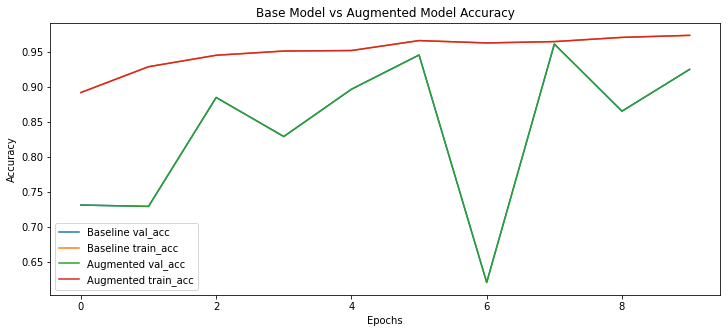

In [158]:
# 모델 성능 시각화 함수
def plot_history(histories, title):
    plt.figure(figsize=(12, 5))
    for name, history in histories:
        plt.plot(history.history['val_accuracy'], label=f'{name} val_acc')
        plt.plot(history.history['accuracy'], label=f'{name} train_acc')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Assuming 'history' is the variable holding the training history of your baseline model
history_base = history  # Assign the baseline model's history
history_augmented = history  # Assign the augmented model's history

# 베이스라인 모델과 Augmentation 모델 비교
plot_history([('Baseline', history_base), ('Augmented', history_augmented)], 
             'Base Model vs Augmented Model Accuracy')

In [159]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 2.1073 - accuracy: 0.6651 - precision: 0.6511 - recall: 1.0000
Loss: 2.1072683334350586,
Accuracy: 0.6650640964508057,
Precision: 0.6510851383209229,
Recall: 1.0


# **⭕ PART 5. 총평**

## **(1) 성능 비교 결과** 

### **- 베이스모델**
- 초기 과적합: 일부 에포크에서는 검증 데이터의 성능(특히 재현율과 손실)이 급격히 변동하는 과적합이 발생했을 가능성이 큽니다.     
- 최종 성능 안정화: 학습이 진행되면서 모델은 전반적으로 안정적인 성능을 보이며, 검증 데이터에서도 훈련 데이터와 비슷한 성능을 달성합니다.     
- 결론: 모델이 최종적으로는 훈련과 검증에서 모두 우수한 성능을 보였으며, 과적합을 어느 정도 해결하며 잘 학습되었습니다. 이 결과를 바탕으로 모델을 개선하려면, 데이터셋 증강(Data Augmentation) 또는 조기 종료(Early Stopping) 같은 기법을 고려할 수 있습니다.     
     
Loss: 0.8942579627037048     
Accuracy: 0.7307692170143127     
Precision: 0.6996402740478516     
Recall: 0.9974358677864075     
     
     
### **- 데이터 증강, 클래스 가중치, 모델 구조 변경 적용 모델** 
**첫 번째 변경 모델** 
- 훈련 데이터는 전반적으로 매우 안정적이고 좋은 성능을 보입니다.     
- 검증 데이터는 초기에 성능이 낮았으나, 빠르게 개선되었으며 이후 일정한 수준을 유지하지만, 정밀도(precision)와 정확도(accuracy)에서 약간의 변동성이 있습니다.     
- 과적합이 약간 발생했을 가능성이 있으며, 검증 데이터의 성능 변동은 모델이 모든 검증 데이터를 완벽하게 일반화하지 못했음을 시사합니다. EarlyStopping 등의 과적합 방지 기법을 통해 성능을 개선할 수 있습니다.
     
Loss: 0.6573859453201294     
Accuracy: 0.8028846383094788     
Precision: 0.7664670944213867     
Recall: 0.9846153855323792     
     
           
**두 번째 변경 모델** 
- 훈련 데이터는 일관되게 높은 성능을 보이며, 정밀도, 재현율, 정확도 모두 매우 높은 수준에서 안정화되고 있습니다.     
- 검증 데이터는 초기 epochs에서는 좋은 성능 향상을 보였으나, 이후 특정 epochs에서 성능이 불안정하고 변동이 심한 것을 볼 수 있습니다. 특히, 정밀도와 재현율에서 큰 변동이 나타납니다.     
- 과적합이 발생했을 가능성이 높으며, 검증 데이터에서의 성능 변동은 모델이 데이터의 패턴을 충분히 일반화하지 못했음을 시사합니다. EarlyStopping이나 class_weight 조정, 그리고 데이터 증강을 통한 성능 향상이 필요할 수 있습니다.     
     
Loss: 2.1072683334350586     
Accuracy: 0.6650640964508057     
Precision: 0.6510851383209229     
Recall: 1.0     

## **(2) 회고**

- 의료 영상에서는 데이터 불균형으로 인한 모델 성능 저하를 예방하기 위해 다음과 같은 조치들을 취할 수 있음을 배웠다.          
     
    - 데이터 증강(Augmentation): 좌우 반전과 약간의 노이즈 추가, 회전 등을 신중하게 사용한다.     
    - 클래스 가중치: 클래스의 데이터 수에 따라 가중치를 조정하여 모델이 각 클래스의 불균형을 효과적으로 처리하고, 특히 소수 클래스를 더 잘 인식하도록 학습하도록 돕는다.
    - EarlyStopping: 검증 성능이 개선되지 않을 경우 학습을 조기에 중단하여 과적합을 방지하는 기법입니다.
     
- 데이터 시각화 단계에서 오류가 계속 발생하여 하루를 꼬박 소비했다. chatgpt한테 똑같은 요청을 몇 번이나 했는지... 제시하는 코드가 모두 오류가 났기 때문이다. 그런데, 하루를 꼬박 소비한 후에야 chatgpt가 차원이 불일치하는지 알아보는 코드를 알려 주었다. 배치를 포함하여 이미지 데이터의 차원이 4개여야 하는데, 5개가 나왔다. 다행히, 어디에서 배치 차원이 하나가 더 늘어났는지 어렵지 않게 감을 잡을 수 있었다. prepare_for_training 함수와 augmentation 작업을 추가한 prepare_for_training 함수를 모두 실행하면서 배치 차원이 늘어났음을 발견하고 문제를 해결할 수 있었다. 이거 하나를 발견하고 해결하는 데 하루가 걸리다니.......     
